# Sciplex2
In this notebook, we load the sciplex2 dataset (1 cell line, 4 drugs, 7 dosages).

In [52]:
%pip install igraph
%pip install leidenalg

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import matplotlib


In [54]:
# change this to the directory that contains the datasets
data_dir = 'C:/Users/nbrouwer1/Documents/VS_projects/prepare_data/input_files/sciplex_selections/'

fn = data_dir + 'sciPlex2_A549_all4_drugs_and_doses.h5ad'

adata_orig = sc.read_h5ad(fn)
adata_orig

c:\Users\nbrouwer1\Documents\VS_projects\prepare_data\.conda\lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 20964 × 35653
    obs: 'i', 'n.umi', 'Size_Factor', 'drug', 'dose', 'count genes expressed', 'ratio mt2non_mt'
    var: 'Ensemble Id'

In [55]:
adata_orig.var_names_make_unique()

In [56]:
df_groups = adata_orig.obs.groupby(by=["drug"]).size()
df_groups

# df_groups.plot(kind='bar', title='Total Points by Team',
            #    ylabel='Total Points', xlabel='Team', figsize=(10, 6))


C:\Users\nbrouwer1\AppData\Local\Temp\ipykernel_948\2062257524.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_groups = adata_orig.obs.groupby(by=["drug"]).size()


drug
BMS       3483
Dex       7370
NAN         81
Nutlin    5259
SAHA      4771
dtype: int64

Count number of gene counts per cell.

<class 'numpy.ndarray'> (20964,)


C:\Users\nbrouwer1\AppData\Local\Temp\ipykernel_948\326829190.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  adata_orig.obs.count_orig = vec_count_sum_orig


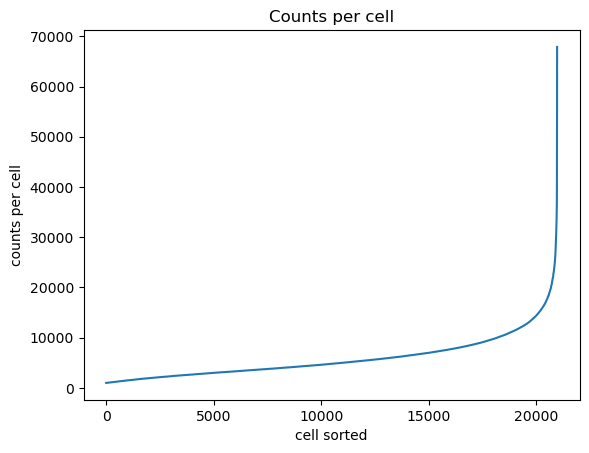

In [57]:
vec_count_sum_orig = adata_orig.X.sum(axis = 1)
vec_count_sum_orig = np.asarray(vec_count_sum_orig).ravel() 
print(type(vec_count_sum_orig), vec_count_sum_orig.shape)
plt.plot( np.sort(vec_count_sum_orig  ) )
plt.xlabel('cell sorted')
plt.ylabel('counts per cell')
plt.title('Counts per cell')
adata_orig.obs.count_orig = vec_count_sum_orig

Apply some standard preprocessing steps.

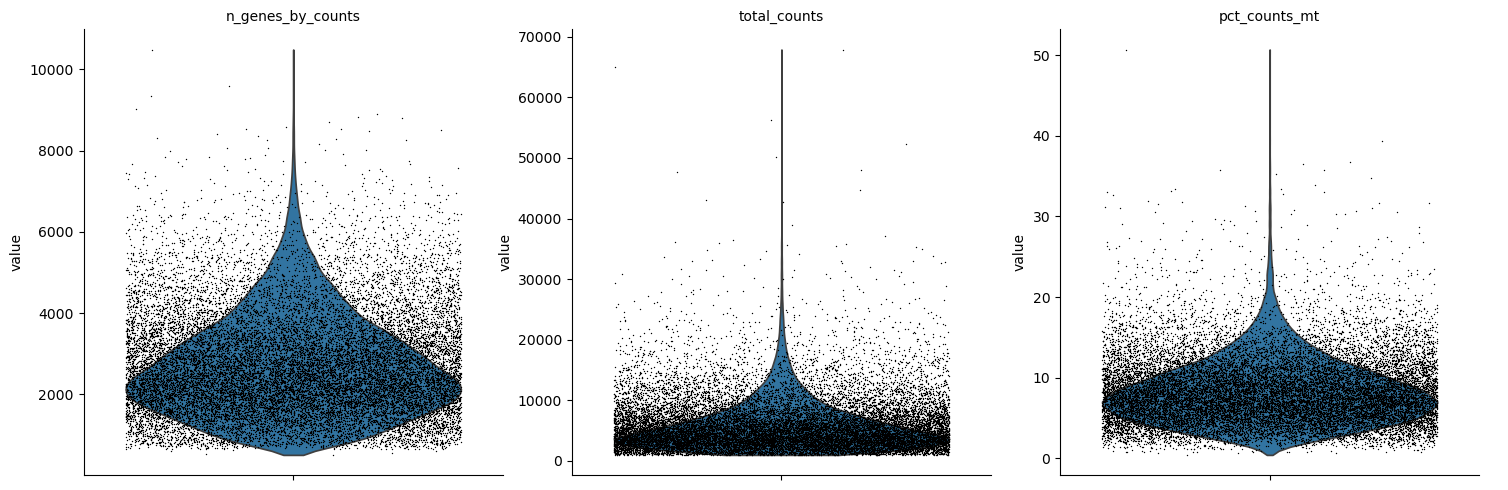

Median total counts = 4811.0
min_count= 500 max_count= 12000


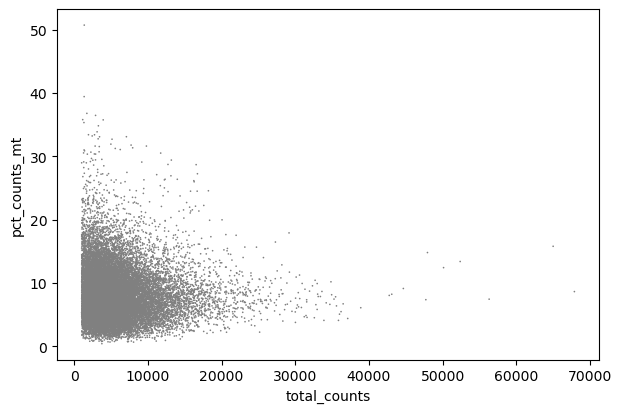

19240 samples pass the count filter
20963  samples pass the mt filter
Samples selected 19239


c:\Users\nbrouwer1\Documents\VS_projects\prepare_data\.conda\lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\nbrouwer1\Documents\VS_projects\prepare_data\.conda\lib\site-packages\scanpy\preprocessing\_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


(19239, 30)

In [58]:
adata = adata_orig

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

#sv.pp.remove_duplicate_cells(adata)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

median_count = np.median(adata.obs['total_counts'])
print('Median total counts =',median_count)
min_count = np.max((median_count/2,5000))

min_count = 500
max_count = 12000

print('min_count=',min_count,'max_count=',max_count)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
inds1 = np.where((adata.obs['total_counts']>min_count) & (adata.obs['total_counts']<max_count))
inds2 = np.where(adata.obs['pct_counts_mt']<50)
print(len(inds1[0]),'samples pass the count filter')
print(len(inds2[0]),' samples pass the mt filter')
ind_samples = np.intersect1d(inds1[0],inds2[0])
print('Samples selected',len(ind_samples))
adata.uns['ind_samples'] = ind_samples

# Here we cut cells. Filtering out those with counts too low or too big
adata = adata[ind_samples,:]

if False:
    X = adata.X.T
    with open(dataset_name+'_umi.txt','w') as f:
        sample_names = list(adata.obs_names)
        f.write('GENE\t'+'\t'.join(sample_names)+'\n')
        print('Number of genes = ',adata.X.shape[1])
        for i in range(adata.X.shape[1]):
            vals = [str(X[i,k]).replace('.0','') for k in range(X.shape[1])]
            f.write(adata.var_names[i]+'\t'+'\t'.join(vals)+'\n')
    print('Saved.')
    
    
sc.pp.normalize_total(adata, target_sum=np.median(adata.obs["total_counts"]))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=10001,n_bins=20)
ind_genes = np.where(adata.var['highly_variable'])[0]

adata = adata[:,ind_genes]
sc.tl.pca(adata,n_comps=30)
X_pca = adata.obsm['X_pca']

adata_orig[ind_samples,ind_genes].var.shape
XX2 = adata_orig[ind_samples,ind_genes].X.toarray()
adata =  anndata.AnnData(XX2,  obs=adata_orig[ind_samples,ind_genes].obs.copy(), 
                     var=adata_orig[ind_samples,ind_genes].var.copy() ) #
adata


X_pca1 = X_pca.copy()
X_pca.shape

Normalize the counts.

In [59]:
print(adata.X[:5,:5])
sc.pp.normalize_total(adata, target_sum=np.median(adata.obs["total_counts"]))
sc.pp.log1p(adata)
print(adata.X[:5,:5])


[[0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0.]
 [0. 0. 0. 4. 0.]
 [0. 0. 1. 0. 0.]]
[[0.        0.        0.        0.        0.       ]
 [0.        0.        0.        2.447869  0.       ]
 [1.7642055 0.        0.        1.7642055 0.       ]
 [0.        0.        0.        2.4208386 0.       ]
 [0.        0.        1.3052132 0.        0.       ]]


In [60]:
adata = adata[adata.obs['drug'] != 'NAN']
adata = adata[adata.obs['dose'] != 'NAN']


## Visualisation
Use PCA or UMAP to visualize the dataset.
The cells are colored based on drug and dose labels.

In [61]:
sc.tl.pca(adata,n_comps=30)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)


c:\Users\nbrouwer1\Documents\VS_projects\prepare_data\.conda\lib\site-packages\scanpy\preprocessing\_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


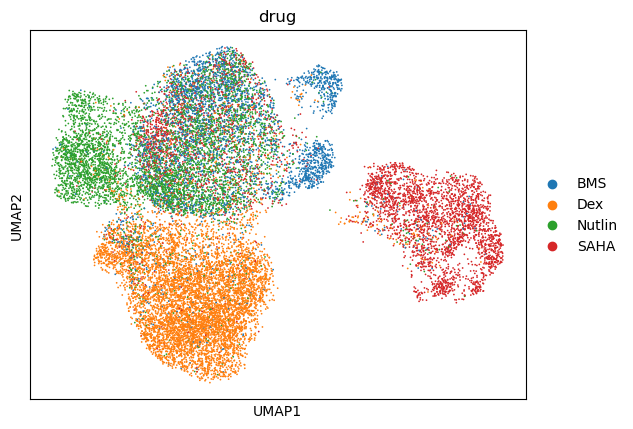

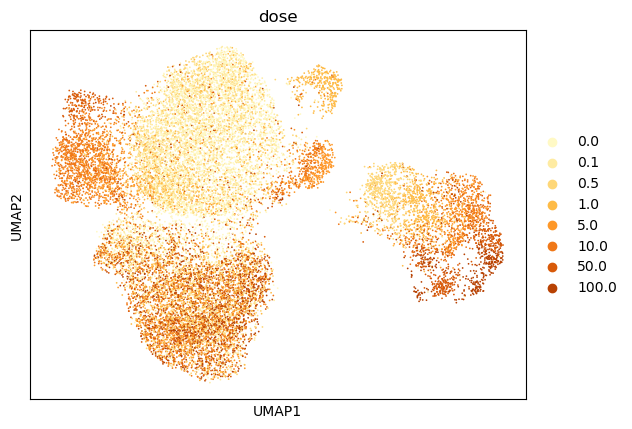

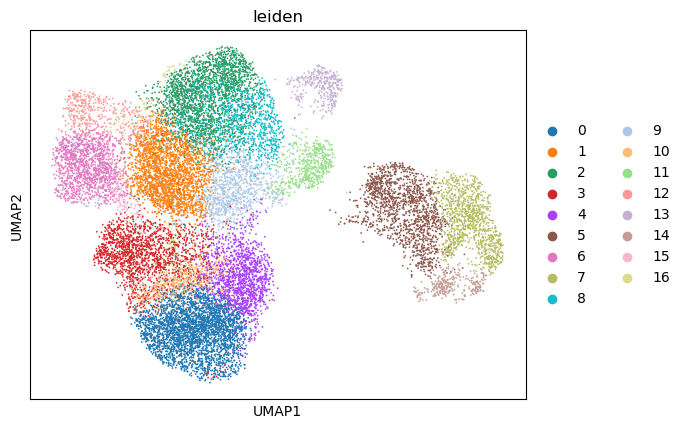

In [62]:
sc.pl.umap(adata, color='drug' )
sc.pl.umap(adata, color='dose', palette=sns.color_palette("YlOrBr", 9))
sc.pl.umap(adata, color='leiden')

treated_label
Other        13599
Untreated     3254
Nutlin         899
Dex            797
SAHA           369
BMS            246
Name: count, dtype: int64


c:\Users\nbrouwer1\Documents\VS_projects\prepare_data\.conda\lib\site-packages\anndata\_core\anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


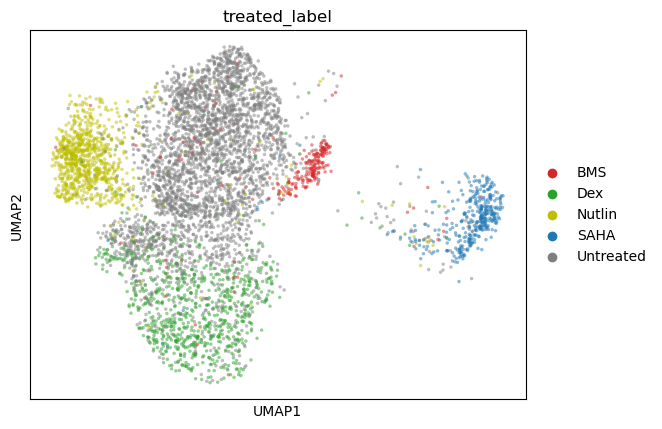

In [63]:
adata.obs['treated_label'] = np.where((adata.obs['dose'] == '0.0'), 'Untreated', adata.obs['drug'])
adata.obs['treated_label'] = np.where((adata.obs['dose'] == '10.0') | (adata.obs['dose'] == '0.0'), adata.obs['treated_label'],'Other' )
print(adata.obs['treated_label'].value_counts())
adata_subset = adata[adata.obs['treated_label'] != 'Other']
sc.pl.umap(adata_subset, color='treated_label',size=25,alpha=0.5, palette={"Untreated": "tab:gray", "BMS": "tab:red", "Dex": "tab:green", "Nutlin":"y", "SAHA":"tab:blue"} )


treated_label
Dex          6214
Nutlin       4016
SAHA         3318
Untreated    3254
BMS          2362
Name: count, dtype: int64


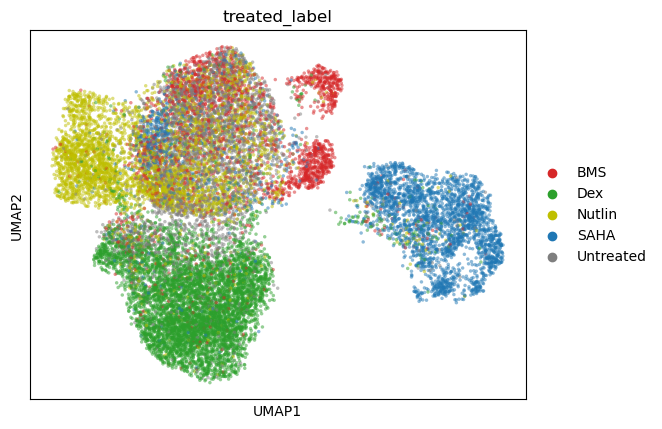

In [64]:
adata.obs['treated_label'] = np.where((adata.obs['dose'] == '0.0'), 'Untreated', adata.obs['drug'])
print(adata.obs['treated_label'].value_counts())
sc.pl.umap(adata, color='treated_label',size=25,alpha=0.5, palette={"Other": (0.1, 0.2, 0.5, 0), "Untreated": "tab:gray", "BMS": "tab:red", "Dex": "tab:green", "Nutlin":"y", "SAHA":"tab:blue", "NAN":(0.1, 0.2, 0.5, 0)} )


## Differential Expression analysis
https://nbisweden.github.io/workshop-scRNAseq/labs/scanpy/scanpy_05_dge.html

c:\Users\nbrouwer1\Documents\VS_projects\prepare_data\.conda\lib\site-packages\anndata\_core\anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


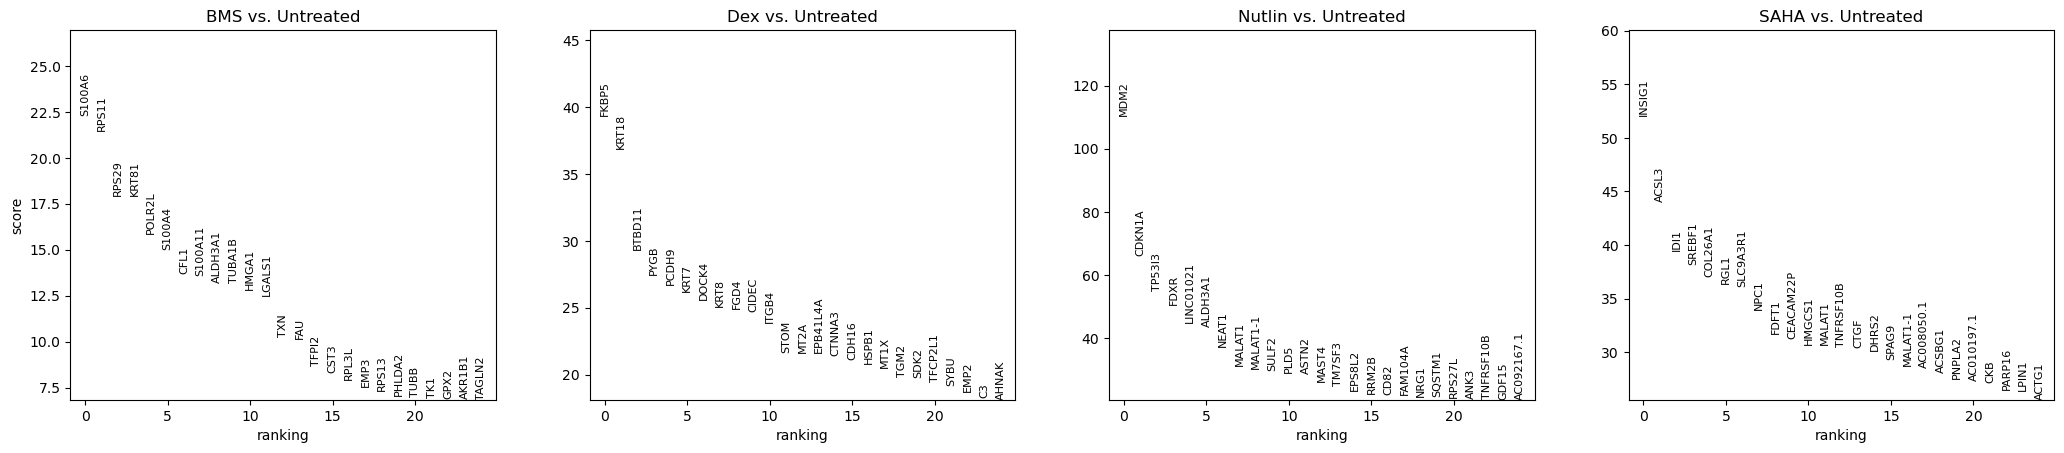

categories: BMS, Dex, Nutlin, etc.
var_group_labels: BMS, Dex, Nutlin, etc.


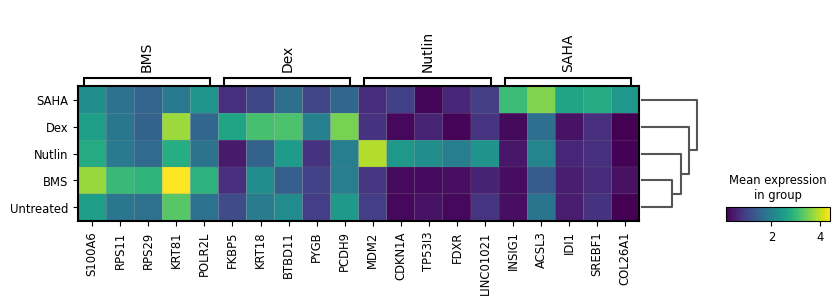

In [65]:
adata.obs['treated_label'] = np.where((adata.obs['dose'] == '0.0'), 'Untreated', adata.obs['drug'])
adata.obs['treated_label'] = np.where((adata.obs['dose'] == '10.0') | (adata.obs['dose'] == '0.0'), adata.obs['treated_label'],'Other' )
adata_subset = adata[adata.obs['treated_label'] != 'Other']

sc.tl.rank_genes_groups(adata_subset, 'treated_label', method='t-test', key_added = "t-test",reference='Untreated')
sc.pl.rank_genes_groups(adata_subset, n_genes=25, sharey=False, key = "t-test")
sc.pl.rank_genes_groups_matrixplot(adata_subset, n_genes=5, key="t-test", groupby="treated_label")

c:\Users\nbrouwer1\Documents\VS_projects\prepare_data\.conda\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


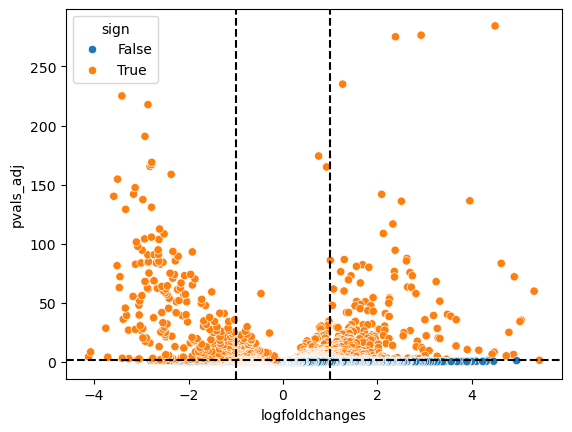

In [102]:
import math
sc.tl.rank_genes_groups(adata_subset, 'treated_label', groups=['Nutlin'], reference='Untreated', method='t-test')
dedf = sc.get.rank_genes_groups_df(adata_subset, group='Nutlin')
dedf['sign'] = np.where(dedf['pvals_adj'] < 0.05, True, False)
dedf = dedf[abs(dedf['logfoldchanges']) < 10]
dedf['pvals_adj'] = -np.log10(dedf['pvals_adj'])
sns.scatterplot(data=dedf, x="logfoldchanges", y="pvals_adj",hue ='sign')
# sc.pl.rank_genes_groups_violin(adata_subset, groups='Nutlin', n_genes=10)
plt.axvline(math.log2(2),linestyle='--',color='black')
plt.axvline(-math.log2(2),linestyle='--',color='black')
plt.axhline(-math.log10(0.05),linestyle='--',color='black')
plt.show()

In [103]:
dedf.sort_values(by='pvals_adj',ascending=False)

,names,scores,logfoldchanges,pvals,pvals_adj,sign
0,MDM2,110.569565,5.054244,0.000000e+00,inf,True
1,CDKN1A,65.946373,5.282460,0.000000e+00,inf,True
2,TP53I3,55.040272,4.280422,0.000000e+00,inf,True
3,FDXR,50.660160,4.494734,2.227158e-288,284.254266,True
4,LINC01021,44.879765,2.927906,1.844366e-280,276.433080,True
...,...,...,...,...,...,...
4669,ARL6IP1P2,0.000000,0.000000,1.000000e+00,-0.000000,False
4670,AC079089.3,0.000000,0.000000,1.000000e+00,-0.000000,False
4671,FCGR1A,0.000000,0.000000,1.000000e+00,-0.000000,False
4672,RN7SL214P,0.000000,0.000000,1.000000e+00,-0.000000,False


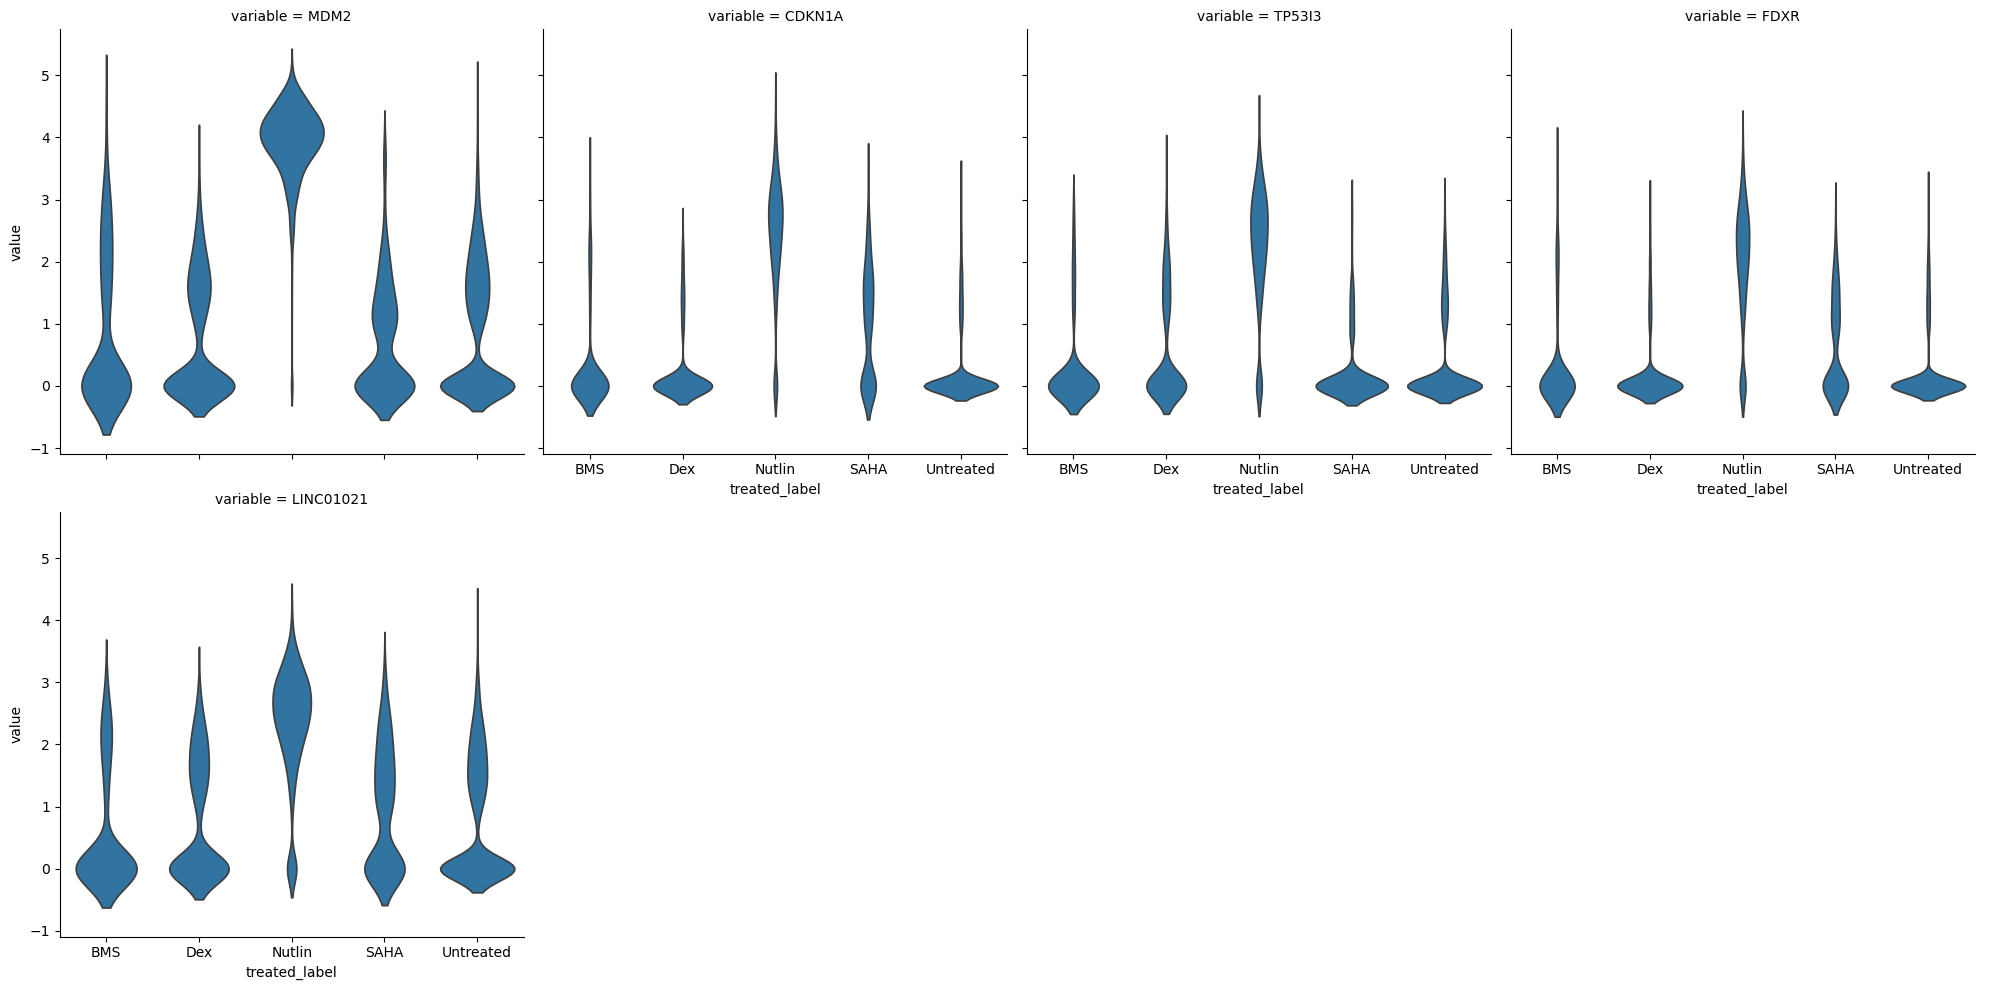

In [104]:
genes = ['MDM2','CDKN1A','TP53I3','FDXR','LINC01021']
df = sc.get.obs_df(adata_subset, genes + ['treated_label'], use_raw=False)
df2 = df.melt(id_vars=["treated_label"], value_vars=genes)
sns.catplot(x = "treated_label", y = "value", kind = 'violin', col = "variable", data = df2, col_wrap=4, inner=None)